# Figure 11: T-S changes between select locations

Import libraries

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import gsw
import time
from dask import dataframe

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[0] )
if module_path not in sys.path:
    sys.path.append(module_path)
import custom_functions as cf

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34367/status,
Dashboard: /proxy/34367/status,Workers: 6
Total threads: 18,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32873,Workers: 6
Dashboard: /proxy/34367/status,Total threads: 18
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:44441,Total threads: 3
Dashboard: /proxy/35249/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:42247,


### Define transit time data files and region for calculation. 

In [5]:
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/universal_density/'
wsttdfiles = sorted(glob(datadir+'ttd_dataframe_WS_-33--65_*varying_sigma1.csv'))
wattdfiles = sorted(glob(datadir+'ttd_dataframe_WA_-103--188_*varying_sigma1.csv'))
rsttdfiles = sorted(glob(datadir+'ttd_dataframe_RS_-188--216_*varying_sigma1.csv'))
eattdfiles = sorted(glob(datadir+'ttd_dataframe_EA_-243-70_*varying_sigma1.csv'))
mgttdfiles = sorted(glob(datadir+'ttd_dataframe_MG_-218-70_*varying_sigma1.csv'))

In [9]:
regions = ['EA02','RS','WA','WS', 'MG']
wmcats = ['aasw','mcdw','dsw']
region = regions[1]
print(region)

if region == 'EA01':
    basinid = 2.
elif region == 'EA02':
    basinid = 3.
    ttdfiles = eattdfiles
elif region == 'MG':
    basinid = 3.
    ttdfiles = mgttdfiles
elif region == 'RS':
    basinid = 4.
    ttdfiles = rsttdfiles
elif region == 'WA':
    basinid = 5.
    ttdfiles = wattdfiles
elif region == 'WS':
    basinid = 7.
    ttdfiles = wsttdfiles

startfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/CircumAntarcticParticles_initial_values.nc'
ref = xr.open_dataset(startfile, decode_cf=False)
idx = np.where(ref.basin == basinid)[0]
ref = ref.isel(trajectory = idx)

RS


### Calculate T-S changes as a function of time between chosen locations

In [10]:
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/parquet_files/shelf_exit/' 

for w in range(len(wmcats)):
    print(wmcats[w])
    dftmp = pd.read_csv(ttdfiles[w])
    ids = np.unique(dftmp.trajectory)
    
    if region == 'MG':
        print('Region is Mertz Polynya')
        parquetfiles = sorted(glob(datadir+'CircumAntarcticParticles_EA02_*.parquet'))
    else:
        parquetfiles = sorted(glob(datadir+'CircumAntarcticParticles_{}_*.parquet'.format(region)))
    df = dataframe.read_parquet(parquetfiles,columns=['lon','lat','z','time','trajectory','thermo','psal'], 
                                split_row_groups=True, engine='pyarrow')
    
    #ids = np.unique(dftmp.trajectory)
    df = df.loc[df['trajectory'].isin(ids)].compute()
    
    # remove zero Temp and Salt values and convert Temp to celsius
    df['thermo']=df['thermo'].replace(0,np.nan)
    df['psal']=df['psal'].replace(0,np.nan)
    df['thermo'] = df['thermo'] - 273.15
    
    # filter for longitude and latitude range of interest
    if region == 'EA02':
        df = df[(df['lon'] < (120-360)) | (df['lon'] > 68) & (df['lat'] <-60)]
    elif region == 'RS':
        df = df[(df['lon'] < (175-360)) & (df['lon'] > (142-360)) & (df['lat'] <-60)]
    elif region == 'WA':
        df = df[(df['lon'] < (-100)) & (df['lon'] > (170-360)) & (df['lat'] <-62)]
    elif region == 'WS':
        df = df[(df['lon'] < (-30)) & (df['lon'] > (-63)) & (df['lat'] <-65.5)]
    
    # convert ref release_time time to dataframe
    refdf = ref.drop_vars(['lat', 'lon', 'z', 'basin','shelf','shelf_exit_T', 
                       'shelf_exit_S', 'shelf_exit_indx','shelf_exit_lon', 
                       'shelf_exit_lat', 'shelf_exit_z', 'shelf_weighted_val', 
                       'temp', 'salt']).sel(trajectory=ids)
    refdf = refdf.to_dataframe().reset_index()
    # merge with dataframe and calcualte crossing_time [time since release]
    df = pd.merge(df, np.abs(refdf), 
             left_on = 'trajectory', 
             right_on = 'trajectory', 
             how='left')
    df['crossing_time'] = df['time'] - df['release_time']*24*60*60
    
    # add absolute salinity and sigma0 to dataframe
    df['p'] = gsw.p_from_z(-df['z'].values, df['lat'].values)
    df['SA'] = gsw.SA_from_SP(df['psal'],df['p'], df['lon'],df['lat'])
    df['sigma0'] = gsw.sigma0(df['SA'],df['thermo'])
    
    if w == 0:
        time_ts = np.arange(0,1513*5,5)#np.unique(df['crossing_time'])/60/60/24
        n_ts = np.zeros((3,len(time_ts)))
        sa_mean = np.zeros((3,len(time_ts)))
        sa_std = np.zeros((3,len(time_ts)))
        temp_mean = np.zeros((3,len(time_ts)))
        temp_std = np.zeros((3,len(time_ts)))
        sigma0_mean = np.zeros((3,len(time_ts)))
        sigma0_std = np.zeros((3,len(time_ts)))
    tn = len(np.unique(df['crossing_time']))
    # save mean and std salt, temp and sigma0
    sa_mean[w,:tn] =  df.groupby('crossing_time').SA.mean()
    sa_std[w,:tn] = df.groupby('crossing_time').SA.std()
    temp_mean[w,:tn] = df.groupby('crossing_time').thermo.mean()
    temp_std[w,:tn] = df.groupby('crossing_time').thermo.std()
    sigma0_mean[w,:tn] = df.groupby('crossing_time').sigma0.mean()
    sigma0_std[w,:tn] = df.groupby('crossing_time').sigma0.std()
    n_ts[w,:tn] = df.groupby('crossing_time').size().values

# convert to dataset
ds = xr.Dataset(
data_vars=dict(sa_mean=(["watermass", "time"], sa_mean),
               sa_std=(["watermass", "time"], sa_std),
               temp_mean=(["watermass", "time"], temp_mean),
               temp_std=(["watermass", "time"], temp_std),
               sigma0_mean=(["watermass", "time"], sigma0_mean),
               sigma0_std=(["watermass", "time"], sigma0_std),
               n_parts=(["watermass", "time"], n_ts),
              ),
coords=dict(watermass=wmcats,
            time=time_ts,
            ),
)  

aasw
mcdw
dsw


Save to file

In [11]:
# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TSchanges/'
outfile = outdir + 'TSchanges_between_TTD_locations_Fig11_{}_varying_sigma1.nc'.format(region)

# Save to netCDF
print("Saving to netCDF file", outfile)
encod={}
for var in ds.data_vars:
    encod[var]={'zlib':True}
ds.to_netcdf(outfile)

Saving to netCDF file /g/data/e14/hd4873/runs/parcels/output/AntConn/data/TSchanges/TSchanges_between_TTD_locations_Fig11_RS_varying_sigma1.nc


### Calculate T-S changes as a function of longitude between chosen locations

In [12]:
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/parquet_files/shelf_exit/' 
dbin = 0.5

for w in range(len(wmcats)):
    print(wmcats[w])
    dftmp = pd.read_csv(ttdfiles[w])
    ids = np.unique(dftmp.trajectory)
    
    if region == 'MG':
        print('Region is Mertz Polynya')
        parquetfiles = sorted(glob(datadir+'CircumAntarcticParticles_EA02_*.parquet'))
    else:
        parquetfiles = sorted(glob(datadir+'CircumAntarcticParticles_{}_*.parquet'.format(region)))
    df = dataframe.read_parquet(parquetfiles,columns=['lon','lat','z','time','trajectory','thermo','psal'], 
                                split_row_groups=True, engine='pyarrow')
    
    #ids = np.unique(dftmp.trajectory)
    df = df.loc[df['trajectory'].isin(ids)].compute()
    
    # remove zero Temp and Salt values and convert Temp to celsius
    df['thermo']=df['thermo'].replace(0,np.nan)
    df['psal']=df['psal'].replace(0,np.nan)
    df['thermo'] = df['thermo'] - 273.15
    
    # filter for longitude and latitude range of interest
    if region == 'EA02':
        df = df[(df['lon'] < (120-360)) | (df['lon'] > 68) & (df['lat'] <-60)]
        lonbins = np.arange(68, 117+dbin, dbin)
    elif region == 'MG':
        df = df[(df['lon'] < (145-360)) | (df['lon'] > 68) & (df['lat'] <-60)]
        lonbins = np.arange(68, 142+dbin, dbin)
    elif region == 'RS':
        df = df[(df['lon'] < (175-360)) & (df['lon'] > (142-360)) & (df['lat'] <-60)]
        lonbins = np.arange(142, 172+dbin, dbin)
    elif region == 'WA':
        df = df[(df['lon'] < (-100)) & (df['lon'] > (170-360)) & (df['lat'] <-62)]
        lonbins = np.arange(170, (-103+360)+dbin, dbin)
    elif region == 'WS':
        df = df[(df['lon'] < (-30)) & (df['lon'] > (-63)) & (df['lat'] <-65.5)]
        lonbins = np.arange(-63, -33+dbin, dbin)
        
    lonbins[lonbins >80] = lonbins[lonbins >80] - 360
    lonbins = np.flip(lonbins)
    print(lonbins)
    
    # convert ref release_time time to dataframe
    refdf = ref.drop_vars(['lat', 'lon', 'z', 'basin','shelf','shelf_exit_T', 
                       'shelf_exit_S', 'shelf_exit_indx','shelf_exit_lon', 
                       'shelf_exit_lat', 'shelf_exit_z', 'shelf_weighted_val', 
                       'temp', 'salt']).sel(trajectory=ids)
    refdf = refdf.to_dataframe().reset_index()
    # merge with dataframe and calcualte crossing_time [time since release]
    df = pd.merge(df, np.abs(refdf), 
             left_on = 'trajectory', 
             right_on = 'trajectory', 
             how='left')
    df['crossing_time'] = df['time'] - df['release_time']*24*60*60
    
    # add absolute salinity and sigma0 to dataframe
    df['p'] = gsw.p_from_z(-df['z'].values, df['lat'].values)
    df['SA'] = gsw.SA_from_SP(df['psal'],df['p'], df['lon'],df['lat'])
    df['sigma0'] = gsw.sigma0(df['SA'],df['thermo'])
    
    if w == 0:
        n_ts = np.zeros((3,len(lonbins)-1))
        sa_mean = np.zeros((3,len(lonbins)-1))
        sa_std = np.zeros((3,len(lonbins)-1))
        temp_mean = np.zeros((3,len(lonbins)-1))
        temp_std = np.zeros((3,len(lonbins)-1))
        sigma0_mean = np.zeros((3,len(lonbins)-1))
        sigma0_std = np.zeros((3,len(lonbins)-1))
    
    for b in range(len(lonbins)-1):
        print(b, lonbins[b], lonbins[b+1])
        # save mean and std salt, temp and sigma0
        if lonbins[b] == -279.5:
            print('lon bin is at -280')
            sa_mean[w,b] =  df[(df['lon'] <= lonbins[b])].groupby('trajectory').mean().SA.mean()
            sa_std[w,b] = df[(df['lon'] <= lonbins[b]) ].groupby('trajectory').mean().SA.std()
            temp_mean[w,b] = df[(df['lon'] <= lonbins[b]) ].groupby('trajectory').mean().thermo.mean()
            temp_std[w,b] = df[(df['lon'] <= lonbins[b]) ].groupby('trajectory').mean().thermo.std()
            sigma0_mean[w,b] = df[(df['lon'] <= lonbins[b]) ].groupby('trajectory').mean().sigma0.mean()
            sigma0_std[w,b] = df[(df['lon'] <= lonbins[b]) ].groupby('trajectory').mean().sigma0.std()
            n_ts[w,b] = df[(df['lon'] <= lonbins[b])].groupby('trajectory').mean().lon.size
        else:
            sa_mean[w,b] =  df[(df['lon'] <= lonbins[b]) & (df['lon'] > lonbins[b+1])].groupby('trajectory').mean().SA.mean()
            sa_std[w,b] = df[(df['lon'] <= lonbins[b]) & (df['lon'] > lonbins[b+1])].groupby('trajectory').mean().SA.std()
            temp_mean[w,b] = df[(df['lon'] <= lonbins[b]) & (df['lon'] > lonbins[b+1])].groupby('trajectory').mean().thermo.mean()
            temp_std[w,b] = df[(df['lon'] <= lonbins[b]) & (df['lon'] > lonbins[b+1])].groupby('trajectory').mean().thermo.std()
            sigma0_mean[w,b] = df[(df['lon'] <= lonbins[b]) & (df['lon'] > lonbins[b+1])].groupby('trajectory').mean().sigma0.mean()
            sigma0_std[w,b] = df[(df['lon'] <= lonbins[b]) & (df['lon'] > lonbins[b+1])].groupby('trajectory').mean().sigma0.std()
            n_ts[w,b] = df[(df['lon'] <= lonbins[b]) & (df['lon'] > lonbins[b+1])].groupby('trajectory').mean().lon.size

# save to dataset
lonmid = (lonbins[0:-1] + lonbins[1:])/2
if region == 'EA02':
    print('Replacing lonmid value at 80E')
    lonmid[73] = -279.75
elif region == 'MG':  
    print('Replacing lonmid value at 80E')
    lonmid[123] = -279.75
ds = xr.Dataset(
data_vars=dict(sa_mean=(["watermass", "lon"], sa_mean),
               sa_std=(["watermass", "lon"], sa_std),
               temp_mean=(["watermass", "lon"], temp_mean),
               temp_std=(["watermass", "lon"], temp_std),
               sigma0_mean=(["watermass", "lon"], sigma0_mean),
               sigma0_std=(["watermass", "lon"], sigma0_std),
               n_parts=(["watermass", "lon"], n_ts),
              ),
coords=dict(watermass=wmcats,
            lon=lonmid,
            ),

)  

aasw
[-188.  -188.5 -189.  -189.5 -190.  -190.5 -191.  -191.5 -192.  -192.5
 -193.  -193.5 -194.  -194.5 -195.  -195.5 -196.  -196.5 -197.  -197.5
 -198.  -198.5 -199.  -199.5 -200.  -200.5 -201.  -201.5 -202.  -202.5
 -203.  -203.5 -204.  -204.5 -205.  -205.5 -206.  -206.5 -207.  -207.5
 -208.  -208.5 -209.  -209.5 -210.  -210.5 -211.  -211.5 -212.  -212.5
 -213.  -213.5 -214.  -214.5 -215.  -215.5 -216.  -216.5 -217.  -217.5
 -218. ]
0 -188.0 -188.5
1 -188.5 -189.0
2 -189.0 -189.5
3 -189.5 -190.0
4 -190.0 -190.5
5 -190.5 -191.0
6 -191.0 -191.5
7 -191.5 -192.0
8 -192.0 -192.5
9 -192.5 -193.0
10 -193.0 -193.5
11 -193.5 -194.0
12 -194.0 -194.5
13 -194.5 -195.0
14 -195.0 -195.5
15 -195.5 -196.0
16 -196.0 -196.5
17 -196.5 -197.0
18 -197.0 -197.5
19 -197.5 -198.0
20 -198.0 -198.5
21 -198.5 -199.0
22 -199.0 -199.5
23 -199.5 -200.0
24 -200.0 -200.5
25 -200.5 -201.0
26 -201.0 -201.5
27 -201.5 -202.0
28 -202.0 -202.5
29 -202.5 -203.0
30 -203.0 -203.5
31 -203.5 -204.0
32 -204.0 -204.5
33 -204.5

Save to file. 

In [13]:
# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TSchanges/'
outfile = outdir + 'TSchanges_between_TTD_locations_Fig11_{}_varying_sigma1_BYLON.nc'.format(region)

# Save to netCDF
print("Saving to netCDF file", outfile)
encod={}
for var in ds.data_vars:
    encod[var]={'zlib':True}
ds.to_netcdf(outfile)

Saving to netCDF file /g/data/e14/hd4873/runs/parcels/output/AntConn/data/TSchanges/TSchanges_between_TTD_locations_Fig11_RS_varying_sigma1_BYLON.nc


### Plot figure
- Coastline is flipped upside down in this figure. 

Read in transit time data.

In [14]:
startfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/CircumAntarcticParticles_initial_values.nc'
ref = xr.open_dataset(startfile, decode_cf=False)

datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/universal_density/'
wsfiles = sorted(glob(datadir+'ttd_dataframe_WS_-33--65_*varying_sigma1.csv'))
wafiles = sorted(glob(datadir+'ttd_dataframe_WA_-103--188_*varying_sigma1.csv'))
rsfiles = sorted(glob(datadir+'ttd_dataframe_RS_-188--216_*varying_sigma1.csv'))
eafiles = sorted(glob(datadir+'ttd_dataframe_EA_-243-70_*varying_sigma1.csv'))
mgfiles = sorted(glob(datadir+'ttd_dataframe_MG_-218-70_*varying_sigma1.csv'))

outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TSchanges/'
outfiles = sorted(glob(outdir + 'TSchanges_between_TTD_locations_Fig11_*_varying_sigma1_BYLON.nc'))

Define plotting functions and data. 

In [15]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)

land_mask_masked = land_mask.where(land_mask == 1)
land_mask_contour = land_mask.copy(deep=True)
land_mask_contour[300:, 800:1000] = 0
land_mask_contour[355:,5:140] = 0
land_mask_contour[225:, 1800:2000] = 0
land_mask_contour[281:286, 2100:2128] = 0
land_mask_contour[335:348, 2123:2128] = 0
land_mask_contour[345:360, 2123:2138] = 0
land_mask_contour[360:368, 2143:2152] = 0
land_mask_contour[367:371, 2148:2158] = 0
land_mask_contour[360:380, 2130:2150] = 0
land_mask_contour[356:380, 2130:2145] = 0 
land_mask_contour[392:415, 2171:2182] = 0 
land_mask_contour[160:, 1700:1760] = 0
land_mask_contour[250:300, 2000:2065] = 0
land_mask_contour[382:400, 2150:2167] = 0 
land_mask_contour[385:400, 2167:2169] = 0
land_mask_contour[387:400, 2169:2172] = 0 
land_mask_contour[388:408, 2215:2260] = 0
land_mask_contour[405:411, 2218:2260] = 0
land_mask[300:, 800:1000] = 0
land_mask[355:,5:140] = 0
land_mask[225:, 1800:2000] = 0


def mercator_plot(axes, extent, xticks, yticks):
    ax3.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='k', linewidths=1.4, zorder=3, alpha = 1, transform = ccrs.PlateCarree())
    ax3.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=1,
                     colors='lightgrey', alpha=0.7, linewidths=1.2, transform = ccrs.PlateCarree())
    ax3.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=1,
                     colors='dimgrey', alpha=1, linewidths=0.5, transform = ccrs.PlateCarree())
    ax3.set_extent(extent)
    ax3.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax3.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax3.xaxis.set_major_formatter(LongitudeFormatter())
    ax3.yaxis.set_major_formatter(LatitudeFormatter())
    ax3.tick_params(axis='x',labelsize=14)
    ax3.tick_params(axis='y',labelsize=14)
    
    
figcolors = ['royalblue', 'tab:orange', 'tab:green']
destcol = 'slategrey'
destxcol = '#525252'
startcol = 'plum'
subplot_labels = ['a)','b)','c)']
distmarkers = ['d', 'v', 's' ,'h', '*','+']
distcols = ['darkorange','gold', 'green', 'dodgerblue', 'blue']
distcols = np.full(len(distcols), 'mediumblue')

Plot figure. 

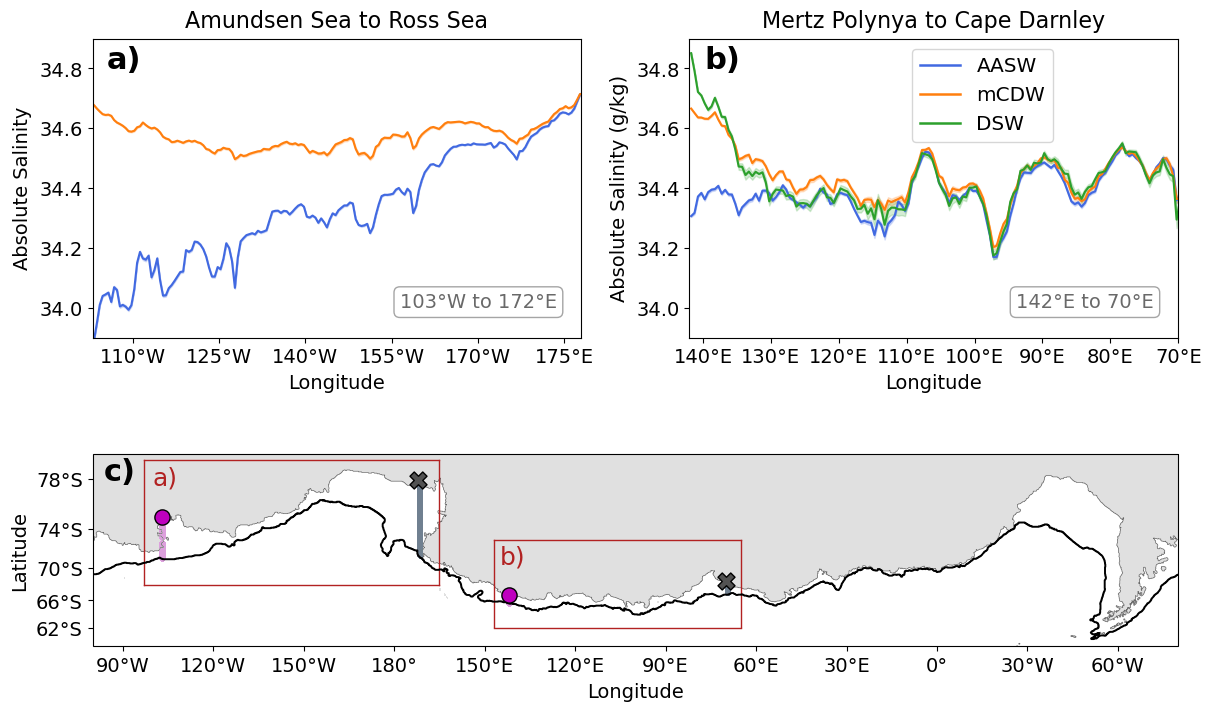

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(12,7))
spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
ax1 = fig.add_subplot(spec[0:2, 0:2], )
ax2 = fig.add_subplot(spec[0:2, 2:4], )
ax3 = fig.add_subplot(spec[2:, :], projection=ccrs.Mercator(central_longitude=100))
fs=14

# SUBPLOT 2 - West Antarctica ====================================================================================
ds = xr.open_dataset(outfiles[-1])
for j in range(3):
    ax1.plot(ds.lon, ds.sa_mean[j,:], c=figcolors[j])
    ax1.fill_between(ds.lon, ds.sa_mean[j,:], ds.sa_mean[j,:]+ds.sa_std[j,:]/np.sqrt(ds.n_parts[j,:]), 
                     color=figcolors[j], alpha=0.2)
    ax1.fill_between(ds.lon, ds.sa_mean[j,:], ds.sa_mean[j,:]-ds.sa_std[j,:]/np.sqrt(ds.n_parts[j,:]), 
                     color=figcolors[j], alpha=0.2)
ax1.set_ylabel(u'Absolute Salinity', fontsize=fs, labelpad=5)
ax1.set_xlim([-188, -103])
ax1.set_ylim([33.9, 34.9])
yticks= [34.0, 34.2, 34.4, 34.6, 34.8]
yticklabels= [34.0, 34.2, 34.4, 34.6, 34.8]
xticks = [-185, -170, -155, -140, -125, -110]
xticklabels = ['175\u00B0E','170\u00B0W','155\u00B0W', '140\u00B0W','125\u00B0W','110\u00B0W']
ax1.set_title('Amundsen Sea to Ross Sea', fontsize = 16, pad=8)
ax1.text(0.95, 0.1, u'103\u00B0W to 172\u00B0E', color='dimgrey', ha='right',fontsize=fs,
    bbox=dict(facecolor='w', edgecolor='dimgrey', alpha=0.6, boxstyle='round,pad=0.3'), 
    transform = ax1.transAxes)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels, fontsize=fs)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels, fontsize=fs)
ax1.set_xlabel('Longitude', fontsize=fs, labelpad=5)
ax1.text(0.03,0.9,subplot_labels[0], fontsize=22, fontweight='bold',transform = ax1.transAxes)
#ax1.text(0.1,0.9,'Amundsen Sea to Ross Sea', fontsize=16, fontweight='normal',transform = ax1.transAxes)
longitudes = [-120,-140,-160,-180]
#for d, lon in enumerate(longitudes):
#    scat = ax1.scatter(lon, 34.9, marker=distmarkers[d], s=100, color=distcols[d], edgecolor='k', zorder=3, )
#    scat.set_clip_on(False)  
ax1.invert_xaxis()
    

# SUBPLOT 2 - East Antarctica - Mertz Polynya to Cape Darnley  ====================================================
ds = xr.open_dataset(outfiles[1])
newlon = np.concatenate((ds.lon[:124]+360, ds.lon[124:]))
for j in range(3):
    tmp_psal_mean = np.concatenate((ds.sa_mean[j,:124], ds.sa_mean[j,124:]))
    tmp_psal_std = np.concatenate((ds.sa_std[j,:124], ds.sa_std[j,124:]))
    tmp_n_parts = np.concatenate((ds.n_parts[j,:124], ds.n_parts[j,124:]))
    
    ax2.plot(newlon, tmp_psal_mean, c=figcolors[j])
    ax2.fill_between(newlon, tmp_psal_mean, tmp_psal_mean+tmp_psal_std/np.sqrt(tmp_n_parts), 
                     color=figcolors[j], alpha=0.2)
    ax2.fill_between(newlon, tmp_psal_mean, tmp_psal_mean-tmp_psal_std/np.sqrt(tmp_n_parts), 
                     color=figcolors[j], alpha=0.2)
ax2.set_xlim([70, 142])
ax2.set_ylim([33.9, 34.9])
yticks= [34.0, 34.2, 34.4, 34.6, 34.8]
yticklabels= [34.0, 34.2, 34.4, 34.6, 34.8]
xticks = [70,80,90,100,110,120,130,140]
xticklabels = ['70\u00B0E','80\u00B0E','90\u00B0E','100\u00B0E','110\u00B0E','120\u00B0E','130\u00B0E','140\u00B0E']
ax2.set_title('Mertz Polynya to Cape Darnley', fontsize = 16, pad=8)
ax2.text(0.95, 0.1, u'142\u00B0E to 70\u00B0E', color='dimgrey', ha='right',fontsize=fs,
        bbox=dict(facecolor='w', edgecolor='dimgrey', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax2.transAxes)
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabels, fontsize=fs)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels, fontsize=fs)
ax2.set_xlabel('Longitude', fontsize=fs, labelpad=5)
ax2.set_ylabel(u'Absolute Salinity (g/kg)', fontsize=fs, labelpad=5)
ax2.text(0.03,0.9,subplot_labels[1], fontsize=22, fontweight='bold',transform = ax2.transAxes)
longitudes = [124, 106, 88]
#for d, lon in enumerate(longitudes):
#    scat = ax1.scatter(lon, 34.9, marker=distmarkers[d], s=100, color=distcols[d], edgecolor='k', zorder=3, )
#    scat.set_clip_on(False)
ax2.invert_xaxis()
    

# SUBPLOT 3 - MAP ===================================================================================================
mercator_plot(ax3, [-80, 240, -79, -59], [-60,-30, 0, 30, 60, 90, 120, 150, 180, -150, -120, -90,], [-78, -74, -70, -66, -62])

# BOX 1
x = np.arange(-195, -96, 1)
y = np.arange(-79.2, -68, 0.1) 
x1 = np.full(len(y), -195)
x2 = np.full(len(y), -97)
y1 = np.full(len(x), -79.2)
y2 = np.full(len(x), -68)
c='firebrick'
ax3.plot(x, y1, c=c, linewidth=1, linestyle = '-',# #af8dc3
            transform = ccrs.PlateCarree())
ax3.plot(x, y2, c=c, linewidth=1, linestyle = '-',# #af8dc3
            transform = ccrs.PlateCarree())
ax3.plot(x1, y, c=c, linewidth=1, linestyle = '-',# #af8dc3
            transform = ccrs.PlateCarree())
ax3.plot(x2, y, c=c, linewidth=1, linestyle = '-',# #af8dc3
            transform = ccrs.PlateCarree())
df = pd.read_csv(wafiles[3])
startlon = -103
idx = np.where(ref.lon == startlon)[0]
startlat = ref.lat[idx].min().values
ax3.scatter(startlon, startlat,marker='o', s=120, c='m', edgecolors='k', zorder=3, transform=ccrs.PlateCarree())
ax3.scatter(ref.lon[idx], ref.lat[idx] ,marker='o', s=10, c=startcol,  zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
ax3.scatter(df['lon'], df['lat'], marker='.', s=1, c=destcol, zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
ax3.scatter(-188, -77.9, marker='X', s=150, color=destxcol, edgecolor='k', zorder=3, transform=ccrs.PlateCarree())
ax3.text(-100, -77.6, subplot_labels[0], fontweight='normal', c=c, fontsize=18, transform=ccrs.PlateCarree())
    
# BOX 2
x = np.arange(65, 148, 1)
y = np.arange(-73, -62, 0.1) 
x1 = np.full(len(y), 65)
x2 = np.full(len(y), 147)
y1 = np.full(len(x), -73)
y2 = np.full(len(x), -62)
ax3.plot(x, y1, c=c, linewidth=1, linestyle = '-',# #af8dc3
            transform = ccrs.PlateCarree())
ax3.plot(x, y2, c=c, linewidth=1, linestyle = '-',# #af8dc3
            transform = ccrs.PlateCarree())
ax3.plot(x1, y, c=c, linewidth=1, linestyle = '-',# #af8dc3
            transform = ccrs.PlateCarree())
ax3.plot(x2, y, c=c, linewidth=1, linestyle = '-',# #af8dc3
            transform = ccrs.PlateCarree())
df = pd.read_csv(mgfiles[3])
startlon = 142-360
idx = np.where(ref.lon == startlon)[0]
startlat = ref.lat[idx].min().values
ax3.scatter(startlon, startlat,marker='o', s=120, c='m', edgecolors='k', zorder=3, transform=ccrs.PlateCarree())
ax3.scatter(ref.lon[idx], ref.lat[idx] ,marker='o', s=10, c=startcol,  zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
ax3.scatter(df['lon'], df['lat'], marker='.', s=1, c=destcol, zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
ax3.scatter(70, -68.5, marker='X', s=150, color=destxcol, edgecolor='k', zorder=3, transform=ccrs.PlateCarree())
ax3.text(145, -70.5, subplot_labels[1], fontweight='normal', fontsize=18, c=c, transform=ccrs.PlateCarree())

ax3.text(0.01,0.86,subplot_labels[2], fontsize=22, fontweight='bold',transform = ax3.transAxes)
ax3.invert_yaxis()
ax3.invert_xaxis()
ax3.set_xlabel('Longitude', fontsize=fs, labelpad=5)
ax3.set_ylabel('Latitude', fontsize=fs, labelpad=5)

line1 = Line2D([0], [0], color=figcolors[0], linestyle='-', linewidth=1.8)
line2 = Line2D([0], [0], color=figcolors[1], linestyle='-', linewidth=1.8)
line3 = Line2D([0], [0], color=figcolors[2], linestyle='-', linewidth=1.8)
labels = ['AASW', 
          'mCDW', 
          'DSW',]
ax2.legend([line1, line2, line3], labels, fontsize = 'x-large',
           loc='upper center', ncol=1, frameon=True, 
           bbox_to_anchor = (0.6,1),
           #bbox_transform = ax2.gcf().transFigure,
           bbox_transform = ax2.transAxes,
          )

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'Fig11_salinity_changes_WA_and_MP_bylongitude_reversed_map.jpg'
fig.savefig(outfile, dpi=300, bbox_inches='tight')